In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader

from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset

from train import setup_human36m_dataloaders

from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation

from IPython.core.debugger import set_trace

%matplotlib inline

retval = {
    'subject_names': ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'],
    'camera_names': ['54138969', '55011271', '58860488', '60457274'],
    'action_names': [
        'Directions-1', 'Directions-2',
        'Discussion-1', 'Discussion-2',
        'Eating-1', 'Eating-2',
        'Greeting-1', 'Greeting-2',
        'Phoning-1', 'Phoning-2',
        'Posing-1', 'Posing-2',
        'Purchases-1', 'Purchases-2',
        'Sitting-1', 'Sitting-2',
        'SittingDown-1', 'SittingDown-2',
        'Smoking-1', 'Smoking-2',
        'TakingPhoto-1', 'TakingPhoto-2',
        'Waiting-1', 'Waiting-2',
        'Walking-1', 'Walking-2',
        'WalkingDog-1', 'WalkingDog-2',
        'WalkingTogether-1', 'WalkingTogether-2']
}

JOINT_H36_DICT = {0:'RFoot',
                 1:'RKnee',
                 2:'RHip',
                 3:'LHip',
                 4:'LKnee',
                 5:'LFoot',
                 6:'Hip',
                 7:'Spine',
                 8:'Thorax',
                 9:'Head',
                 10:'RWrist',
                 11:'RElbow',
                 12:'RShoulder',
                 13:'LShoulder',
                 14:'LElbow',
                 15:'LWrist',
                 16:'Neck/Nose'}

JOINT_NAMES_DICT = {
                    0: "nose",
                    1: "left_eye",
                    2: "right_eye",
                    3: "left_ear",
                    4: "right_ear",
                    5: "left_shoulder",
                    6: "right_shoulder",
                    7: "left_elbow",
                    8: "right_elbow",
                    9: "left_wrist",
                    10: "right_wrist",
                    11: "left_hip",
                    12: "right_hip",
                    13: "left_knee",
                    14: "right_knee",
                    15: "left_ankle",
                    16: "right_ankle"
                }

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

device = 'cuda:0'
OFFSET = 12

In [11]:
# experiment_type = 'resnet_50/stack_3d'
# experiment_name='h36_sv32_dist_stack3d-interpolate-gn_s2v-v2v-256-256-64-gn_vf64_f2v-backbone-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@19.03.2020-23:02:34'

# experiment_type = 'resnet_50/stack_2d'
# experiment_name = 'h36_sv32_dist_stack-unproject-gn_s2v-lstm2d-256-128-64-gn_vf32-v2v-conf_f2v-backbone-noupscale-C4-256-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@12.03.2020-22:37:17'

experiment_type = 'resnet_50/adain_1d'
experiment_name = 'h36_sv32_dist_adain-all-gn_s2v-lstm-1024-1024-1024-gn_vf32_f2v-backbone-C4-1024-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@12.03.2020-19:00:21'     

# experiment_type = 'resnet_50/baseline'
# experiment_name = 'h36_sv32_dist_resnet50-gn_v2v-v1-gn-no-aggr_1-1_lr-1e-4_boneloss-1e-4@19.03.2020-19:21:45'

experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
config_path = experiment_root + '/config.yaml'

config = cfg.load_config(config_path)
# config.dataset.val.retain_every_n_frames_in_test = 1

_, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=False,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.val.keypoints_per_frame if hasattr(config.dataset.val, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


SyntaxError: invalid syntax (<ipython-input-11-e785726b179f>, line 1)

# Check dataset output

In [4]:
# config.model.cuboid_multiplier = 1.0
# config.model.rotation = False
# config.model.transfer_cmu_to_human36m = False
# config.model.encoder_normalization_type = 'group_norm'
# config.model.upscale_bottleneck = False
# config.model.f2v_intermediate_channels = config.model.intermediate_channels    
# config.model.f2v_normalization_type = 'group_norm'   
# config.model.v2v_type = 'v1'
# config.model.spade_broadcasting_type = 'unprojecting'

    
model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M params
features_sequence_to_vector:  8.4M params
encoder:  11.06M params
volume_net:  21.05M params
process_features:  0.01M params
Loaded vol_temporal_adain model


In [5]:
checkpoints_path = experiment_root + '/checkpoints/'
weights_path = checkpoints_path + '/weights.pth'
model.load_state_dict(torch.load(weights_path)['model_state'], strict=True)
print ('Done')

Done


# Check model output

In [6]:
# for batch in train_loader:
#     images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device)
#     break

# (keypoints_3d_pred, 
# features_pred, 
# volumes_pred, 
# confidences_pred, 
# cuboids_pred, 
# coord_volumes_pred, 
# base_points_pred) = model(images_batch, batch)    

# Helper functions


In [14]:
def get_start_stop_frame_indxs(labels):
    
    frame_idx = labels['table']['frame_idx']
    change_mask = np.concatenate((frame_idx[:-1] > frame_idx[1:], [True]))
    stop_frame_indxs = frame_idx[change_mask]
    
    videos_lengths = stop_frame_indxs+1
    stop_indexes = np.cumsum(videos_lengths) - 1
    
    start_indexes = np.array([0] + list(stop_indexes + 1)[:-1])
    
    return start_indexes, stop_indexes

def index_to_name(i_stop, stop_indexes, val=True):
    sublects = ['S9', 'S11']
    actions = retval['action_names']
    
    number = np.arange(len(stop_indexes))[i_stop <= stop_indexes][0]
    subject_number = number//len(actions)
    action_number = number % len(actions)
    return sublects[subject_number], actions[action_number]

def get_error_diffs(keypoints_gt, keypoints_pred):
    
    rmse = lambda x,y: np.sqrt((x-y)**2).mean()
    assert len(keypoints_gt) == len(keypoints_pred) 
    n_frames = len(keypoints_gt)
    
    gt_diffs, pred_diffs = [], []
    
    for i in range(1,n_frames):

        if KIND == "mpii":
            root_index = 6 
        else:
            raise RuntimeError()

        keypoints_gt_relative = keypoints_gt - keypoints_gt[:, root_index:root_index + 1, :]
        keypoints_pred_relative = keypoints_pred - keypoints_pred[:, root_index:root_index + 1, :]

        per_pose_error_relative = np.sqrt(((keypoints_gt_relative - keypoints_pred_relative) ** 2).sum(2)).mean(1)
        
        gt_diffs.append(rmse(keypoints_gt[i], keypoints_gt[i-1]))
        pred_diffs.append(rmse(keypoints_pred, keypoints_pred[i-1]))

    pred_diffs = np.array(pred_diffs)
    gt_diffs = np.array(gt_diffs)
    
    return per_pose_error_relative, gt_diffs, pred_diffs

In [15]:
labels=val_loader.dataset.labels
start_frame_indexes, stop_frame_indxs=get_start_stop_frame_indxs(labels)

### define ###
length=250
action = 'Directions-1'
subject = 'S9'
camera_index = 0
##############

action_index=retval['action_names'].index(action)
offset = len(retval['action_names']) if subject == 'S11' else 0
start=start_frame_indexes[offset:][action_index].item()

assert length%batch_size==0
assert subject in ['S9', 'S11']
assert subject, action == index_to_name(start+length, stop_frame_indxs)

# Collect keypoints from multiview

In [16]:
def normalize_temporal_images_batch(images_batch, pivot_position):
    images_batch = images_batch[:,pivot_position]
    # normalize images batch
    images_batch = image_batch_to_numpy(images_batch.detach().cpu())
    images_batch = denormalize_image(images_batch).astype(np.uint8)
    images_batch = images_batch[..., ::-1]  # bgr -> rgb
    return images_batch

In [17]:
USE_RANDOM_STYLE_VECTOR = True
USE_CONSTANT_STYLE_VECTOR = True
RETURN_STYLE_VECTOR = True
RETURN_UNPROJ_FEATURES = True
ADD_IMAGES = True

KIND = model.kind
series = defaultdict(list)
series['images'] = defaultdict(list)
series['proj_matrices'] = defaultdict(list)
eval_view = 0 # supported [0,1,2,3] cameras
collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

model.eval()
with torch.no_grad():
    for i in tqdm_notebook(range(start,start+length)):
        ##############
        # EVALUATION #
        ##############
        batch = val_loader.dataset.__getitem__(i + eval_view*val_loader.dataset.n_sequences)
        if batch is None:
            'Batch is none...'
            break
        
        batch = collate_fn([batch])
        (images_batch, 
        keypoints_3d_gt, 
        keypoints_3d_validity_batch_gt, 
        proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
        
        if config.model.name == 'vol_temporal_adain':
            output = model(images_batch, 
                           batch, 
                           return_style_vector=RETURN_STYLE_VECTOR, 
                           return_unproj_features=RETURN_UNPROJ_FEATURES)
            if RETURN_STYLE_VECTOR and RETURN_UNPROJ_FEATURES:
                series['style_vectors'].append(output[-2].detach().cpu().numpy())
                series['unproj_features'].append(output[-1].detach().cpu().numpy())
            elif RETURN_STYLE_VECTOR:
                series['style_vectors'].append(output[-1].detach().cpu().numpy())
            elif RETURN_UNPROJ_FEATURES:
                series['unproj_features'].append(output[-1].detach().cpu().numpy())
            else:
                pass
        else:    
            output = model(images_batch, batch)
        torch.cuda.empty_cache()
        
        if USE_RANDOM_STYLE_VECTOR:
            randomized_output = model(images_batch, batch, randomize_style=True)
            keypoints_3d_pred_random_style = randomized_output[0]
            keypoints_random_style = keypoints_3d_pred_random_style.detach().cpu().numpy()
            series['keypoints_random_style'].append(keypoints_random_style)
            torch.cuda.empty_cache()
            
        if USE_CONSTANT_STYLE_VECTOR:
            const_output = model(images_batch, batch, const_style_vector=True, return_style_vector=True)
            keypoints_3d_pred_const_style = const_output[0]
            keypoints_const_style = keypoints_3d_pred_const_style.detach().cpu().numpy()
            series['keypoints_const_style'].append(keypoints_const_style)
            series['style_vectors_const'].append(const_output[-1].detach().cpu().numpy())
            torch.cuda.empty_cache()    

        keypoints_3d_pred = output[0]
        batch_size, n_views, n_joints = keypoints_3d_gt.shape[:3]

        # normalize all stuff
        proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
        images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
        keypoints = keypoints_3d_pred.detach().cpu().numpy()
        keypoints_gt =  keypoints_3d_gt.detach().cpu().numpy()
        
        series['keypoints'].append(keypoints)
        series['keypoints_gt'].append(keypoints_gt)
        
        if ADD_IMAGES:
            series['images'][eval_view].append(images_batch)
            series['proj_matrices'][eval_view].append(proj_matricies_batch)
        
        ##############
        # PROJECTING #
        ##############
        for view_i in range(4):
            if view_i == eval_view:
                continue
            else:
                batch = val_loader.dataset.__getitem__(i + view_i*val_loader.dataset.n_sequences)
                batch = collate_fn([batch])
                
                (images_batch, 
                keypoints_3d_gt, 
                keypoints_3d_validity_batch_gt, 
                proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
                
                # normalize all stuff
                proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
                images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
                
                if ADD_IMAGES:
                    series['images'][view_i].append(images_batch)
                    series['proj_matrices'][view_i].append(proj_matricies_batch)
        
series['keypoints'] = np.concatenate(series['keypoints'],0)
series['keypoints_gt'] = np.concatenate(series['keypoints_gt'],0)
if USE_RANDOM_STYLE_VECTOR:
    series['keypoints_random_style'] = np.concatenate(series['keypoints_random_style'],0)
if RETURN_UNPROJ_FEATURES:
    series['unproj_features'] = np.concatenate(series['unproj_features'],0) 
if RETURN_STYLE_VECTOR:
    series['style_vectors'] = np.concatenate(series['style_vectors'],0) 
if USE_CONSTANT_STYLE_VECTOR:
    series['keypoints_const_style'] = np.concatenate(series['keypoints_const_style'],0) 
    series['style_vectors_const'] = np.concatenate(series['style_vectors_const'],0)   
if ADD_IMAGES:    
    for i in range(4):
        series['images'][i] = np.concatenate(series['images'][i],0)
        series['proj_matrices'][i] = np.concatenate(series['proj_matrices'][i],0)

/nfs/hpc2_storage/ibulygin/learnable-triangulation-pytorch/mvn/models/volumetric_adain.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  style_vector = torch.tensor(self.STYLE_VECTOR_CONST).to(device)


In [18]:
# check const-style-vectors
if USE_CONSTANT_STYLE_VECTOR:
    flag = []
    for i in range(length):
        for j in range(length): 
            flag += [(series['style_vectors_const'][j] == series['style_vectors_const'][i]).all()]
    print (all(flag)) 

True


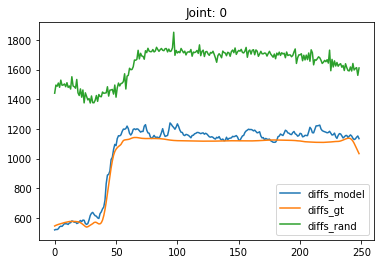

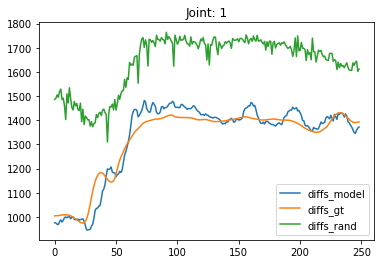

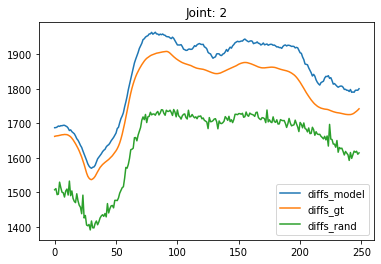

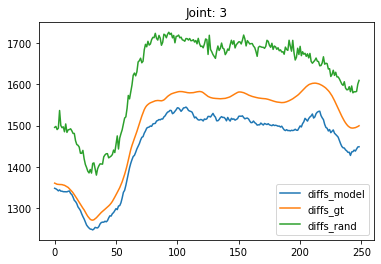

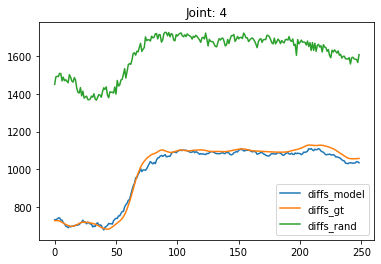

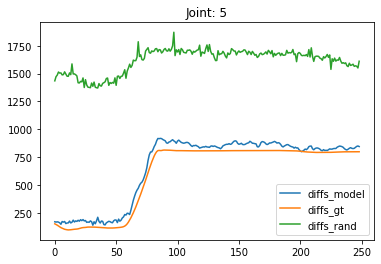

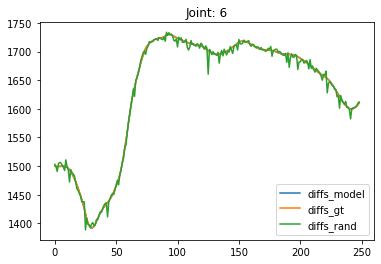

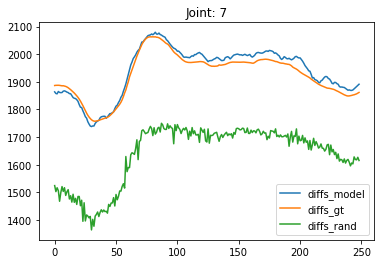

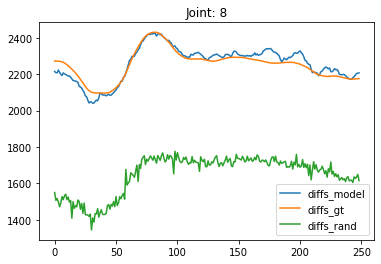

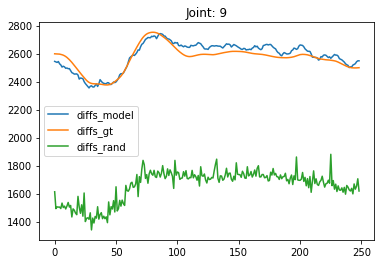

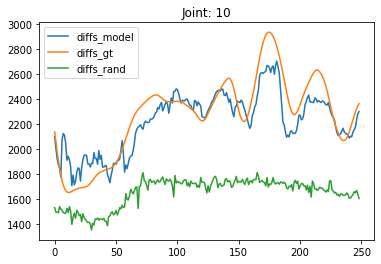

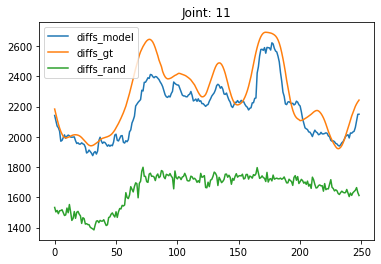

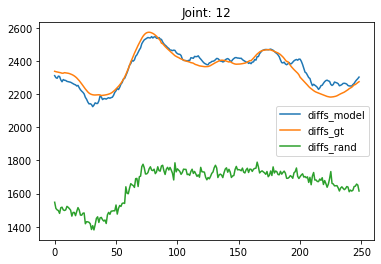

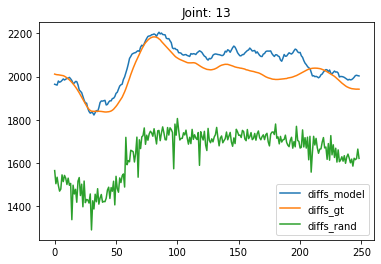

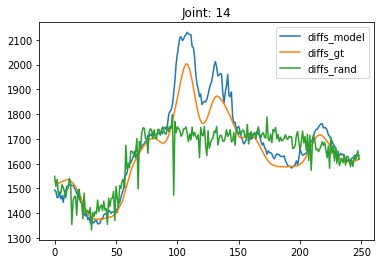

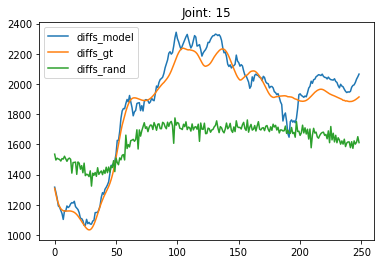

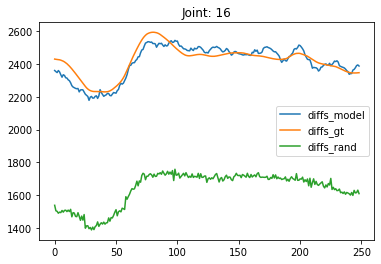

In [24]:

for joint in range(17):
    diffs_model = []
    diffs_gt = []
    diffs_rand = []
    
    for i in range(1, length):
        diffs_model.append(np.linalg.norm(series['keypoints'][i,joint] - np.linalg.norm(series['keypoints'][i-1,joint])))
        diffs_gt.append(np.linalg.norm(series['keypoints_gt'][i,joint] - np.linalg.norm(series['keypoints_gt'][i-1,joint])))
        diffs_rand.append(np.linalg.norm(series['keypoints_random_style'][i,joint] - np.linalg.norm(series['keypoints_random_style'][i-1,joint])))
        
    plt.figure()
    plt.plot(diffs_model, label = 'diffs_model')
    plt.plot(diffs_gt, label = 'diffs_gt')
    plt.plot(diffs_rand, label = 'diffs_rand')
                          
    plt.title(f'Joint: {joint}')
    plt.legend()

# Plot error

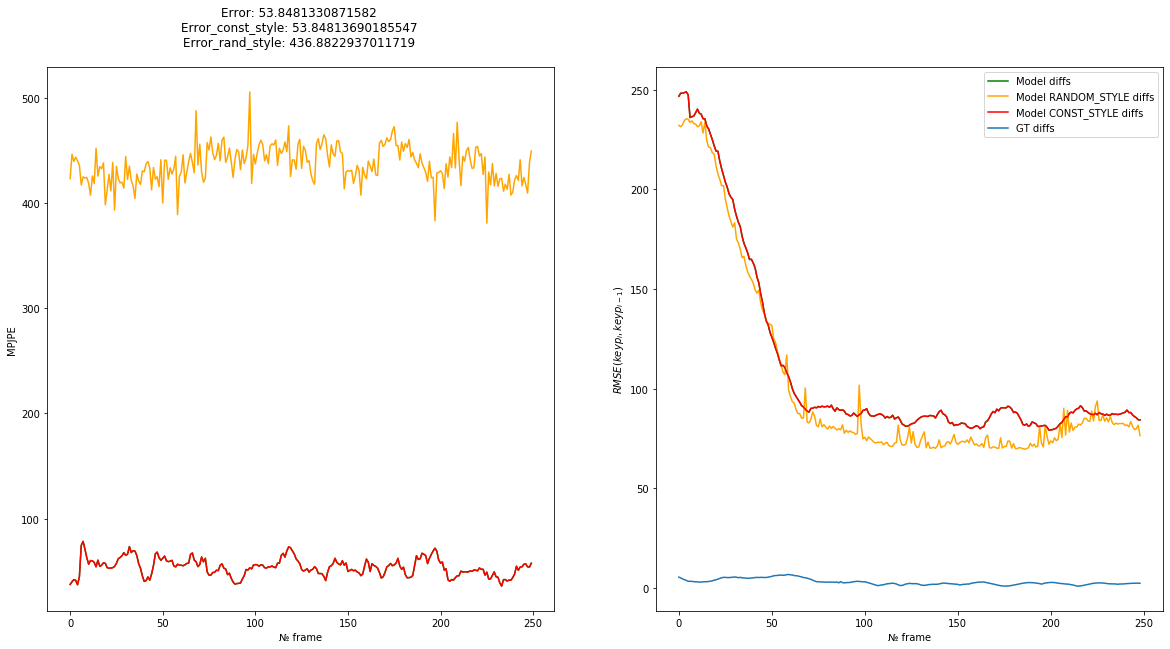

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
error, gt_diffs, model_diffs = get_error_diffs(series['keypoints_gt'], series['keypoints'])

#########
# ERROR #   
#########
ax1.plot(error, 'g', label='Error')
title = f"Error: {error.mean()} \n"

if USE_CONSTANT_STYLE_VECTOR:
    error_const_style, _, model_diffs_const_style = get_error_diffs(series['keypoints_gt'], series['keypoints_const_style'])
    ax1.plot(error_const_style, 'red', label='Error')
    title += f"Error_const_style: {error_const_style.mean()} \n"

if USE_RANDOM_STYLE_VECTOR:
    error_rand_style, _, model_diffs_rand_style = get_error_diffs(series['keypoints_gt'], series['keypoints_random_style'])
    ax1.plot(error_rand_style, 'orange', label='Error')
    title += f"Error_rand_style: {error_rand_style.mean()} \n"

ax1.set_xlabel('№ frame')
ax1.set_ylabel('MPJPE')
ax1.set_title(title)

#########
# DIFFS #   
#########
ax2.plot(model_diffs, 'g',label='Model diffs')

if USE_RANDOM_STYLE_VECTOR:
    ax2.plot(model_diffs_rand_style, 'orange',label='Model RANDOM_STYLE diffs')
if USE_CONSTANT_STYLE_VECTOR:
    ax2.plot(model_diffs_const_style, 'red',label='Model CONST_STYLE diffs')    

ax2.plot(gt_diffs, label='GT diffs')
ax2.set_xlabel('№ frame')
ax2.set_ylabel(r'$RMSE(keyp_{i}, keyp_{i-1})$')
ax2.legend()


# Debug

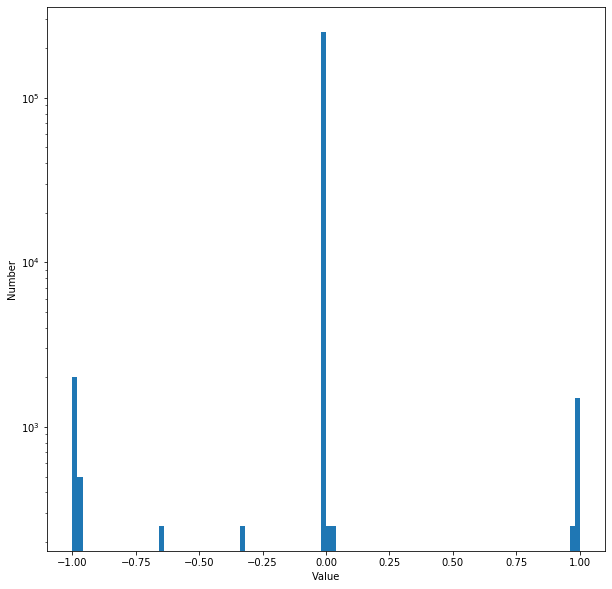

In [25]:
style_vectors = series['style_vectors']
unproj_features = series['unproj_features']
plt.figure(figsize=(10,10))
plt.hist(style_vectors.flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Value')
plt.ylabel('Number')

# plt.show()
# plt.close('all')
plt.savefig(f"{os.path.join(experiment_root, 'hist')}", dpi=280)


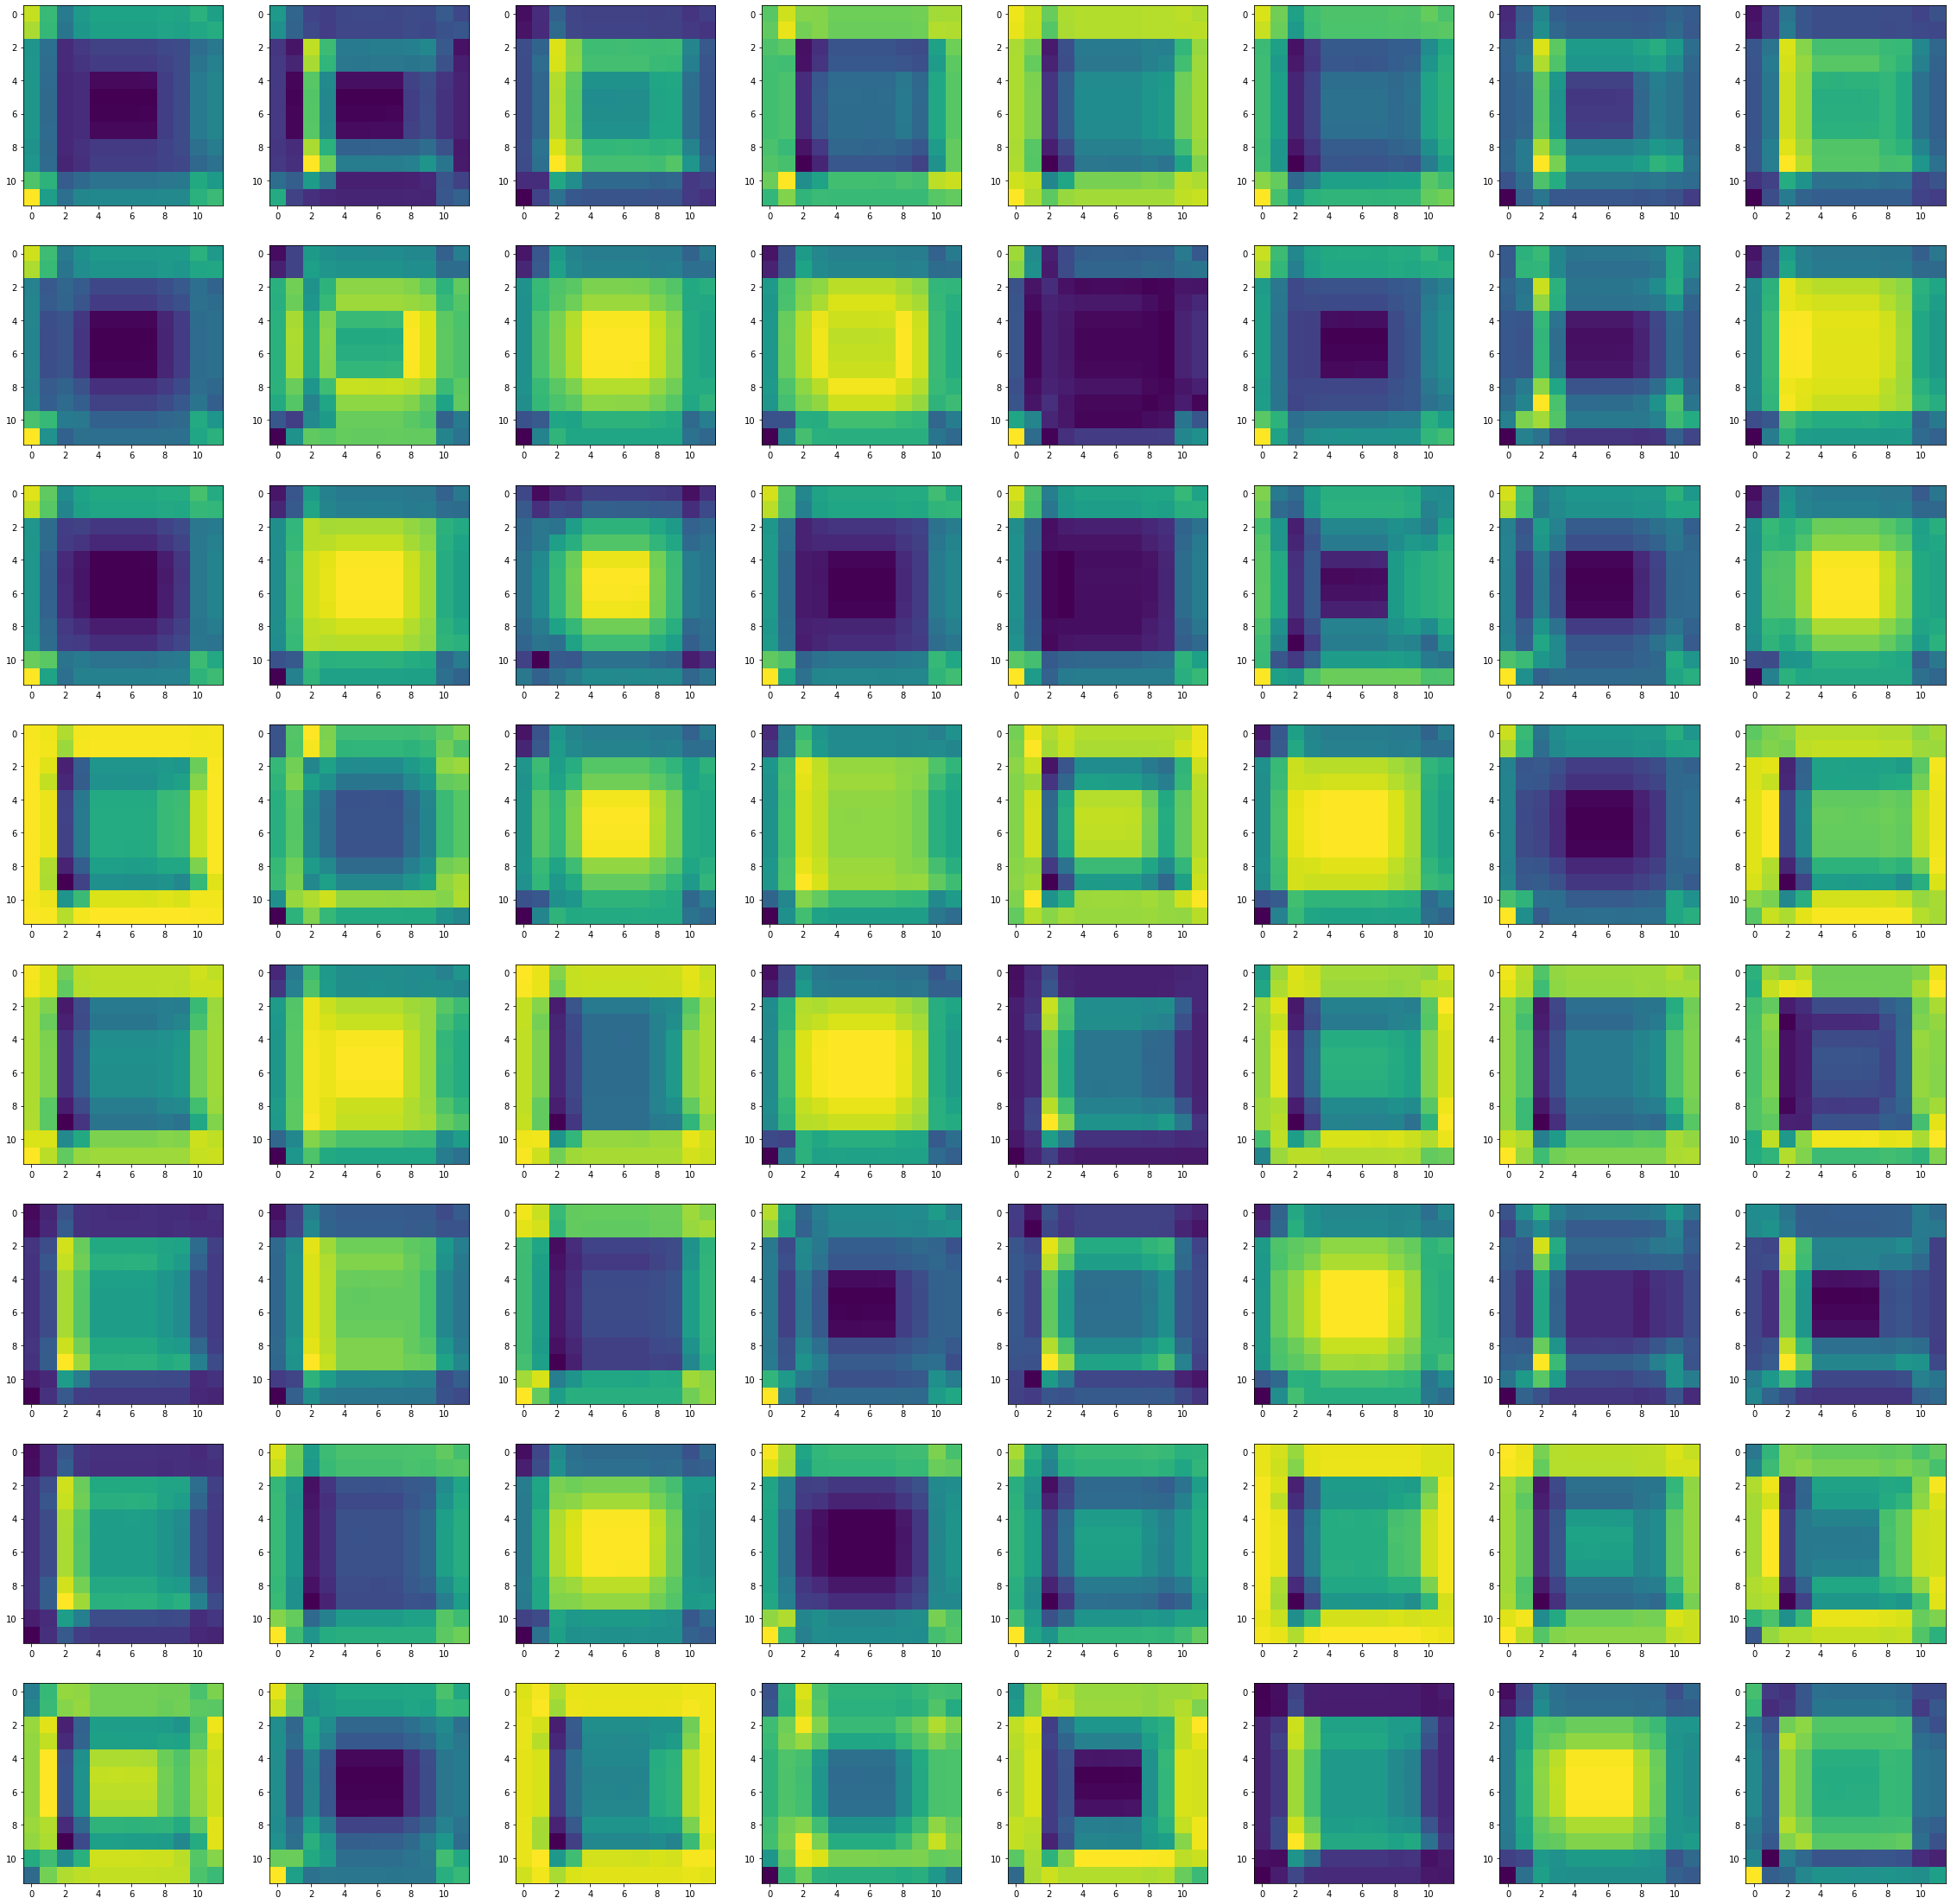

In [32]:
n_frame = 0
time_step = 0

if experiment_type[-2:] == '2d':
    n_style_channels = style_vectors.shape[-3]
    n = int(np.sqrt(n_style_channels))
    fig, axes = plt.subplots(ncols=n, nrows=n, figsize=(n*5,n*5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(style_vectors[n_frame, 0, i])
        
elif experiment_type[-2:] == '3d':
    n_style_channels = style_vectors.shape[-4]
    n = int(np.sqrt(n_style_channels))
    fig, axes = plt.subplots(ncols=n, nrows=n, figsize=(n*5,n*5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(style_vectors[n_frame, i, time_step])  
        
        

In [50]:
MAKE_UNPROJ_FEATUES_VIDEOS = True
N_UNPROJ_FEATUES_VIDEO_FRAMES = 5

video_path = os.path.join(experiment_root, 'videos')
if not os.path.isdir(video_path):
    os.makedirs(video_path)
    print ('video_path - Created')
else:
    print ('video_path - Already exists')

video_subject_action_path = os.path.join(video_path,'{0}_{1}'.format(subject, action))
    
features_dir = os.path.join(video_subject_action_path,'unproj_features_video')
if not os.path.isdir(features_dir):
    os.makedirs(features_dir)
    print ('features_dir - Created')
else:
    print ('features_dir - Already exists')       

if MAKE_UNPROJ_FEATUES_VIDEOS:
    for frame in tqdm_notebook(range(N_UNPROJ_FEATUES_VIDEO_FRAMES)):
        for spatial_slice in range(unproj_features.shape[2]):
            number = (unproj_features.shape[2] * frame) + spatial_slice
            n_volume_channels = unproj_features.shape[-4]
            n = int(np.sqrt(n_volume_channels))
            fig, axes = plt.subplots(ncols=n, nrows=n, figsize=(n*5,n*5))
            for i, ax in enumerate(axes.flatten()):
                ax.imshow(unproj_features[n_frame, i, spatial_slice])
            fig.suptitle(f'FRAME {frame}', fontsize=50)    
            plt.savefig('./{}/img_{:05}.jpg'.format(features_dir, number), bbox_inches='tight', dpi=300)
            plt.close('all')
    os.system(f"ffmpeg -framerate 25 -i {features_dir}/img_%05d.jpg -vcodec mpeg4 -y {video_subject_action_path}/unproj_features_video.mp4")

        

video_path - Already exists
features_dir - Already exists


In [55]:
features_dir

'../logs/resnet_50/stack_3d/h36_sv32_dist_stack3d-interpolate-gn_s2v-v2v-256-256-64-gn_vf64_f2v-backbone-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@19.03.2020-23:02:34/videos/S9_Directions-1/unproj_features_video'

In [54]:
# from subprocess import call
# call(["ffmpeg", "-framerate 25", f"-i {features_dir}/img_%05d.jpg", "-vcodec mpeg4", f"-y {video_subject_action_path}/unproj_features_video.mp4"])

In [26]:
ptp = style_vectors.reshape(length, -1).ptp(0)
var = style_vectors.reshape(length, -1).var(0)

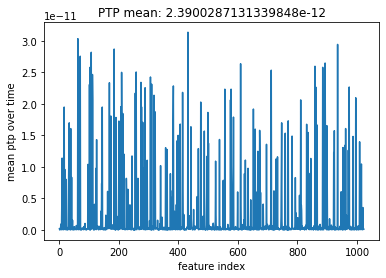

In [28]:
plt.plot(ptp)
plt.title(f'PTP mean: {ptp.mean()}')
plt.ylabel('mean ptp over time')
plt.xlabel('feature index')
plt.savefig(f"{os.path.join(experiment_root, 'ptp')}", dpi=280)        


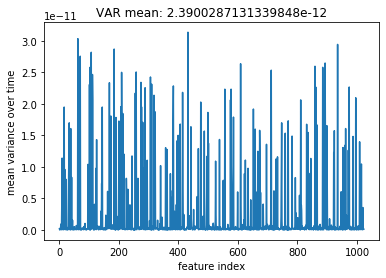

In [29]:
plt.plot(ptp)
plt.title(f'VAR mean: {ptp.mean()}')
plt.ylabel('mean variance over time')
plt.xlabel('feature index')
plt.savefig(f"{os.path.join(experiment_root, 'ptp')}", dpi=280)        


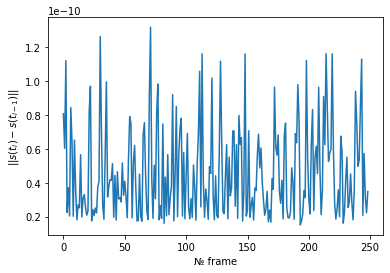

In [30]:
style_diffs = []
for i in range(1,length):
    style_diffs.append(np.linalg.norm(style_vectors[i] - style_vectors[i-1]))
plt.plot(style_diffs) 
plt.xlabel('№ frame')
plt.ylabel(r'$||s(t_i) - s(t_{i-1}) ||$')

plt.savefig(f"{os.path.join(experiment_root, 'style_diffs')}", dpi=280)        



# Post processing

In [17]:
# from scipy.signal import savgol_filter, savgol_coeffs
# n_joints = series['keypoints'].shape[1]
# series['keypoints_smoothed'] = []
# for i in range(n_joints):
#     joint_coord_sequence = series['keypoints'][:,i]
#     series['keypoints_smoothed'] += [savgol_filter(joint_coord_sequence, window_length=25, polyorder = 2, axis=0)]
# series['keypoints_smoothed'] = np.stack(series['keypoints_smoothed'], 1)

In [18]:
# coord=1
# joint = 3
# plt.plot(series['keypoints_smoothed'][:,joint,coord][:20],'r', label='smoothed')
# plt.plot(series['keypoints'][:,joint,coord][:20], label='original')
# plt.legend()

# Make Video

In [37]:
video_path = os.path.join('videos/',experiment_type, experiment_name)
if not os.path.isdir(video_path):
    os.makedirs(video_path)
    print ('video_path - Created')
else:
    print ('video_path - Already exists')
    
keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
if not os.path.isdir(keypoints_dir):
    os.makedirs(keypoints_dir)
    print ('keypoints_dir - Created')
else:
    print ('keypoints_dir - Already exists')        

video_path - Created
keypoints_dir - Created


In [53]:
x = torch.tensor([[0,0,0,1,0,0,0],
                  [0,0,0,1,0,0,0],
                  [0,0,0,1,0,0,0],
                  [1,1,1,1,1,1,1],
                  [0,0,0,1,0,0,0],
                  [0,0,0,1,0,0,0],
                  [0,0,0,1,0,0,0]], dtype=torch.float32)

x2 = F.interpolate(x.unsqueeze(0).unsqueeze(1), size=(14,14)) # , mode='trilinear'

In [54]:
x.shape, x2

(torch.Size([7, 7]), torch.Size([1, 1, 14, 14]))

In [55]:
x2[0,0]

tensor([[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

In [41]:
with_gt = True
with_random_style = True
add_per_joint_description = True
for i in tqdm_notebook(range(length)):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
    for view in range(4):

        # unpack
        image = series['images'][view][i]
        proj_matrice = series['proj_matrices'][view][i]
        keypoints_3d_gt = series['keypoints_gt'][i]
        keypoints_3d_pred = series['keypoints'][i] #if not with_random_style else series['keypoints_random_style'][i]

        ax_i = ax.flatten()[view]
        ax_i.imshow(image)

        pjpe = np.linalg.norm(keypoints_3d_gt - keypoints_3d_pred, axis=-1)

        # predicted keypoints
        keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                    keypoints_3d_pred)
        draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

        if with_gt:
            keypoints_2d_gt_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                        keypoints_3d_gt)
            draw_2d_pose(keypoints_2d_gt_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')

        if view == eval_view and add_per_joint_description:
            ax_i.set_title(f'EVAL_VIEW, MPJPE: {pjpe.mean()}', fontsize=34)
            text = ''.join([j_name + f': ~{int(pjpe[j_n])}' + '\n' for j_n,j_name in JOINT_H36_DICT.items()])
            h,w = image.shape[:2]
            offset_1, offset_2 = 5,10
            ax_i.text(0+offset_1, h-offset_2, text, style='italic', fontsize=25,
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    # plt.show()      
    plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight', dpi=100)
    plt.close('all')


# Compare Normal style winth Random style

In [ ]:
keypoints_3d_pred_original
keypoints_3d_ranom_style

plt.fugure()
# predicted keypoints
keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                            keypoints_3d_pred_original)
draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

plt.fugure()
# predicted keypoints
keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                            keypoints_3d_ranom_style)
draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

# Compare models video

In [34]:
# video_path = os.path.join('videos/','baseline_vs_adain')
# if not os.path.isdir(video_path):
#     os.makedirs(video_path)
#     print ('video_path - Created')
# else:
#     print ('video_path - Already exists')
    
# keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
# if not os.path.isdir(keypoints_dir):
#     os.makedirs(keypoints_dir)
#     print ('keypoints_dir - Created')
# else:
#     print ('keypoints_dir - Already exists')        

In [33]:
# series_baseline = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol.npy', allow_pickle=True).item()
# series_model = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol_temporal_adain.npy', allow_pickle=True).item()
# add_per_joint_description = False

# offset = abs(series_baseline['keypoints_gt'] - series_model['keypoints_gt'][0]).sum(-1).sum(-1).argmin()

# for i in tqdm_notebook(range(20)):

#     fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
#     for view in range(4):

#         # unpack
#         image = series_model['images'][view][:-offset][i]
#         proj_matrice = series_model['proj_matrices'][view][:-offset][i]
        
#         keypoints_3d_baseline = series_baseline['keypoints'][offset:][i]
#         keypoints_3d_model = series_model['keypoints'][:-offset][i]
        
#         keypoints_3d_gt_model = series_model['keypoints_gt'][:-offset][i]
#         keypoints_3d_gt_baseline = series_baseline['keypoints_gt'][offset:][i]
        
#         assert (keypoints_3d_gt_model == keypoints_3d_gt_baseline).all()
        
#         ax_i = ax.flatten()[view]
#         ax_i.imshow(image)

#         pjpe_baseline = round(np.linalg.norm(keypoints_3d_gt_baseline - keypoints_3d_baseline, axis=-1).mean(),2)
#         pjpe_model = round(np.linalg.norm(keypoints_3d_gt_model - keypoints_3d_model, axis=-1).mean(),2)
        
#         # predicted keypoints
#         keypoints_2d_baseline_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                          keypoints_3d_baseline)
#         draw_2d_pose(keypoints_2d_baseline_proj,ax_i,kind='human36m', point_size=200, line_width=5)

#         keypoints_2d_model_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                     keypoints_3d_model)
#         draw_2d_pose(keypoints_2d_model_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')
    
#         ax_i.set_title(f'MPJPE: model-{pjpe_model}, baseline-{pjpe_baseline}', fontsize=34)
    
    
#     plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight')
#     plt.close()        
